#Importing data and library

In [1]:
#this will take around 13 minutes to process

#Download Data
!git clone -b patch-1 --single-branch https://github.com/iiscleap/Coswara-Data.git
#Extract Data
!python /content/Coswara-Data/extract_data.py /content/Coswara-Data/
#After extraction delete the compressed files to save disk space
!rm -rf /content/Coswara-Data/20* 
#Installing libraries
!pip install python_speech_features
!pip install librosa

Streaming output truncated to the last 5000 lines.
20200820/Axei3vO2YcQM56PrwqmMF40A6aG3/vowel-a.wav
20200820/Axei3vO2YcQM56PrwqmMF40A6aG3/vowel-e.wav
20200820/Axei3vO2YcQM56PrwqmMF40A6aG3/breathing-shallow.wav
20200820/Axei3vO2YcQM56PrwqmMF40A6aG3/counting-fast.wav
20200820/Axei3vO2YcQM56PrwqmMF40A6aG3/breathing-deep.wav
20200820/Axei3vO2YcQM56PrwqmMF40A6aG3/cough-heavy.wav
20200820/Axei3vO2YcQM56PrwqmMF40A6aG3/cough-shallow.wav
20200820/Y635Ri3QFMcOKC0ckXgW2r0xJ422/counting-normal.wav
20200820/Y635Ri3QFMcOKC0ckXgW2r0xJ422/metadata.json
20200820/Y635Ri3QFMcOKC0ckXgW2r0xJ422/vowel-o.wav
20200820/Y635Ri3QFMcOKC0ckXgW2r0xJ422/vowel-a.wav
20200820/Y635Ri3QFMcOKC0ckXgW2r0xJ422/vowel-e.wav
20200820/Y635Ri3QFMcOKC0ckXgW2r0xJ422/breathing-shallow.wav
20200820/Y635Ri3QFMcOKC0ckXgW2r0xJ422/counting-fast.wav
20200820/Y635Ri3QFMcOKC0ckXgW2r0xJ422/breathing-deep.wav
20200820/Y635Ri3QFMcOKC0ckXgW2r0xJ422/cough-heavy.wav
20200820/Y635Ri3QFMcOKC0ckXgW2r0xJ422/cough-shallow.wav
20200820/Tfvspm3rapd3ZL

#Loading Data and Libraries

In [5]:
import pandas as pd
import shutil
import os
import scipy.io.wavfile 
from tqdm import tqdm
import librosa
import functools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from python_speech_features import mfcc, logfbank
from tensorflow.keras.utils import to_categorical
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from scipy.io.wavfile import read as wavread
from scipy.io import wavfile
cos_path='/content/Coswara-Data/'
extract=cos_path+'Extracted_data/'

In [6]:
df= pd.read_csv(cos_path+"combined_data.csv")
df.head(5)

,id,a,covid_status,record_date,ep,g,l_c,l_l,l_s,rU,smoker,cold,ht,diabetes,cough,ctDate,ctScan,ctScore,diarrhoea,fever,loss_of_smell,mp,testType,test_date,test_status,um,vacc,bd,others_resp,ftg,st,ihd,asthma,others_preexist,cld,pneumonia
0,iV3Db6t1T8b7c5HQY2TwxIhjbzD3,28,healthy,2020-04-23,y,male,India,Anantapur,Andhra Pradesh,n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AxuYWBN0jFVLINCBqIW5aZmGCdu1,25,healthy,2020-04-20,y,male,India,BENGALURU URBAN,Karnataka,n,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C5eIsssb9GSkaAgIfsHMHeR6fSh1,28,healthy,2020-04-24,y,female,United States,Pittsburgh,Pennsylvania,n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YjbEAECMBIaZKyfqOvWy5DDImUb2,26,healthy,2020-04-23,y,male,India,Bangalore,Karnataka,n,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aGOvk4ji0cVqIzCs1jHnzlw2UEy2,32,healthy,2020-04-22,y,male,India,Nalanda,Bihar,n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#EDA

##Analyzing cough heavy samples

In [7]:
# Assigning path as column
df = df.assign(coughheavy = lambda a: a['record_date'].str.replace('-','')+'/'+a['id']+'/cough-heavy.wav')

In [8]:
#remove recodrs for which files are missing
from collections import defaultdict
errorinfiles = {"MissingFiles":[],"EmptyFiles":[]}
def isSilent(p):
  samplerate, data = wavread(p)
  return True if sum(data)==0 else False

# analyzing length of each type of audio files
for index,row in df.iterrows():
  filepath=extract+row.coughheavy
  if not os.path.exists(filepath):
    errorinfiles["MissingFiles"].append(filepath)
    df=df.drop(index, axis=0) 
  elif isSilent(filepath):
    errorinfiles["EmptyFiles"].append(filepath)
    df=df.drop(index, axis=0) 
  else:
    rate, signal =wavfile.read(filepath)
    df.at[index,'coughheavy_length']=signal.shape[0]/rate
    


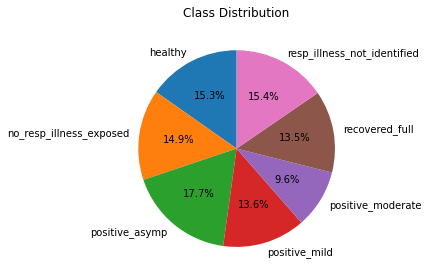

In [11]:



classes=list(np.unique(df.covid_status))

class_dist=df.groupby(['covid_status'])['coughheavy_length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index,autopct='%1.1f%%',
	shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [12]:
# Helper functions
from python_speech_features import mfcc, logfbank
signals ={}
fft ={}
fbank ={}
mfccs ={}
figsiz=(35,3)
title_y=1.1

def plot_signals(signals):
  fig,axes=plt.subplots(nrows=1,ncols=len(list(signals.keys())),sharex=False,sharey=True,figsize=figsiz)
  fig.suptitle('Time Series',size=16,y=title_y)
  i=0
  for y in range(len(list(signals.keys()))):
    axes[y].set_title(list(signals.keys())[i])
    axes[y].plot(list(signals.values())[i])
    i +=1
  plt.show()

def plot_fft(fft):
 fig,axes=plt.subplots(nrows=1,ncols=len(list(fft.keys())),sharex=False,sharey=True,figsize=figsiz)
 fig.suptitle('Fourier Transforms',size=16,y=title_y)
 i=0
 for y in range(len(list(fft.keys()))):
   data=list(fft.values())[i]
   Y, freq=data[0],data[1]
   axes[y].set_title(list(fft.keys())[i])
   axes[y].plot(freq,Y)
   i +=1
 plt.show()

def plot_fbank(fbank):
 fig,axes=plt.subplots(nrows=1,ncols=len(list(fbank.keys())),sharex=False,sharey=True,figsize=figsiz)
 fig.suptitle('Filter Bank Coefficients',size=16,y=title_y)
 i=0
 for y in range(len(list(fbank.keys()))):
   axes[y].set_title(list(fbank.keys())[i])
   axes[y].imshow(list(fbank.values())[i],cmap='hot',interpolation='nearest')
   i +=1
 plt.show()

def plot_mfccs(mfccs):
 fig,axes=plt.subplots(nrows=1,ncols=len(list(mfccs.keys())),sharex=False,sharey=True,figsize=figsiz)
 fig.suptitle('Mel Frequency Cepstrum Coefficients',size=16,y=title_y)
 i=0
 for y in range(len(list(mfccs.keys()))):
   axes[y].set_title(list(mfccs.keys())[i])
   axes[y].imshow(list(mfccs.values())[i],cmap='hot',interpolation='nearest')
   i +=1
 plt.show()

def calc_fft(y,rate):
 n=len(y)
 freq=np.fft.rfftfreq(n,d=1/rate)
 Y=abs(np.fft.rfft(y)/n)
 return (Y, freq)

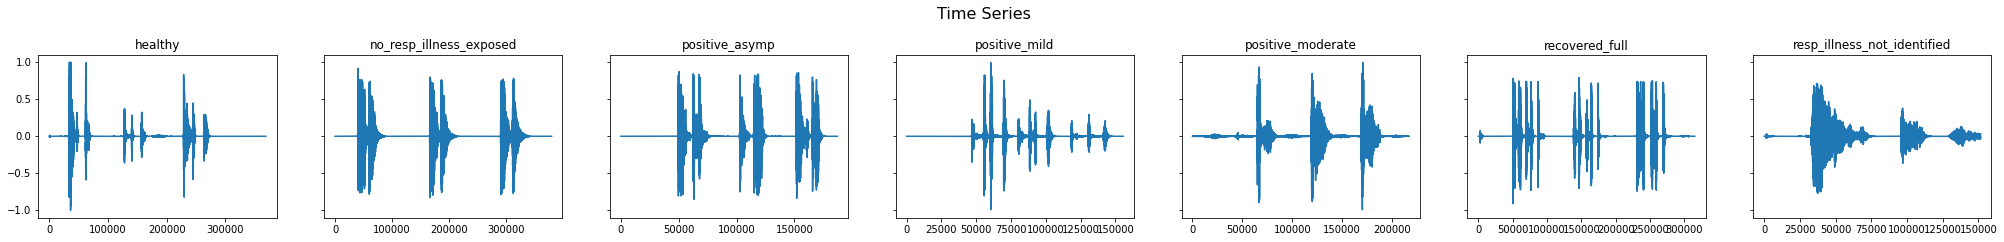

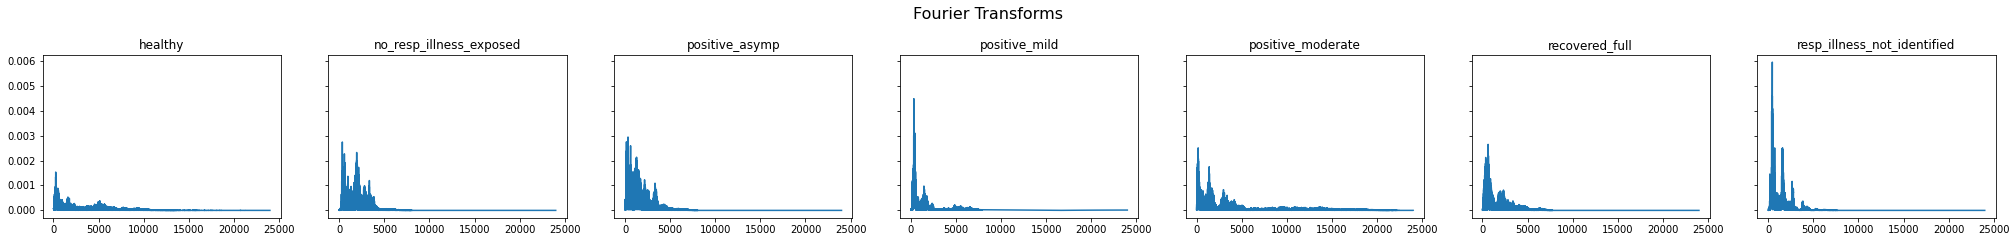

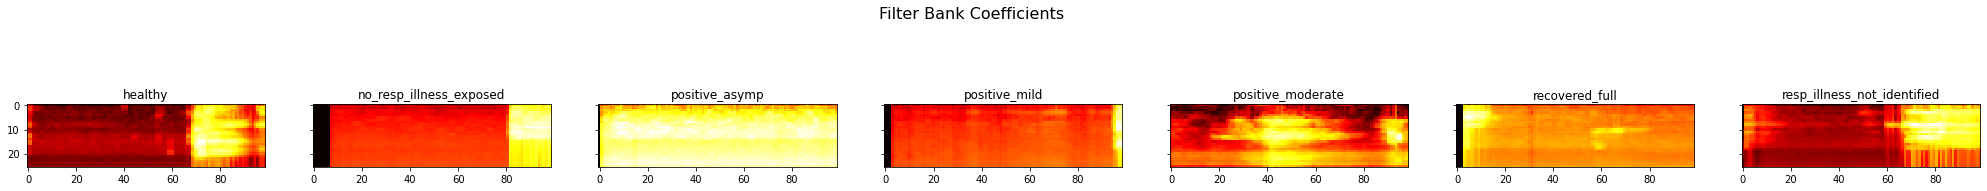

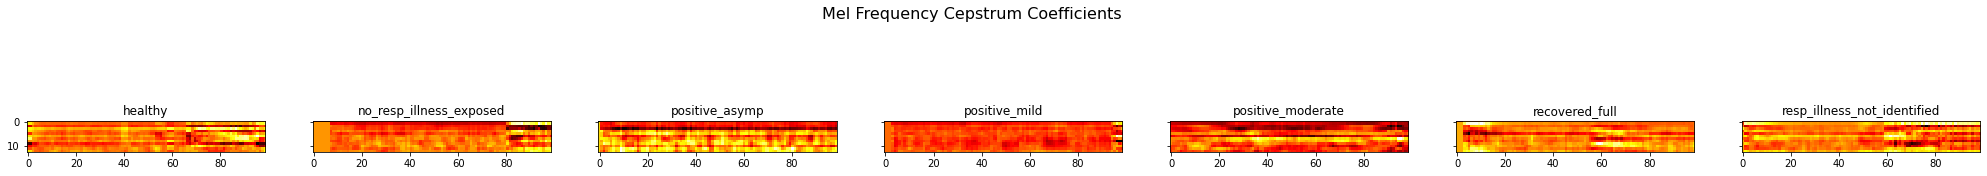

In [13]:


classes=list(np.unique(df.covid_status))

for c in classes:
  filepath=f'{extract}{df[df.covid_status==c].coughheavy.values[0]}'
  #signal, rate =wavfile.read(filepath)
  signal, rate =librosa.load(filepath,sr=48000)
  signals[c]=signal
  fft[c]=calc_fft(signal,rate)
  bank=logfbank(signal[:rate],rate,nfilt=26,nfft=1200).T
  fbank[c]=bank
  mel=mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=1200).T
  mfccs[c]=mel

plot_signals(signals)
plot_fft(fft)
plot_fbank(fbank)
plot_mfccs(mfccs)